# Plotting just the skirt EW data as a phase curve

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
pd.set_option('display.max_rows', None)

# analyze_tau version that only applies tau correction to core range (but, includes all points in optimization)

In [9]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata

In [10]:
# Define other functions
    
# optimize for best-fit tau, HG param method
def optimize_tau_hg(obsdata, nstd=None):
    best_tau = None
    best_std = 1e38
    
    for tau in np.arange(0.000, 0.101, 0.001):
        hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, nstd, obsdata, col_tau=('Normal EW', tau))
        
        if hg_std < best_std:
            best_std = hg_std
            best_tau = tau

    print()
    print(f'** Best Tau: {best_tau:.3f}')
    return best_tau


def phase_curve(hg_used_data, phase_col, uc_ew_col, ew_col, hg_params, best_tau):
    
    plt.figure(figsize=(10,3))

    #plot the uncorrected points
    plt.subplot(1, 2, 1)
    plt.scatter(hg_used_data[phase_col], hg_used_data[uc_ew_col], c='midnightblue')
    plt.xlabel('Phase Angle (°)')
    plt.ylabel('Normal EW')
    plt.title('Normal EW vs. Phase Angle (uncorrected)')

    #plot the corrected points + model
    plt.subplot(1, 2, 2)
    plt.scatter(hg_used_data[phase_col], hg_used_data[ew_col], c='midnightblue')
    
    #plot the phase curve
    xrange = np.arange(hg_used_data[phase_col].min(), hg_used_data[phase_col].max()+1)
    hg_phase_model = hg_func(hg_params, xrange)
    plt.plot(xrange, hg_phase_model, '-', color='tab:red', lw=2, label='Phase model')
    
    plt.xlabel('Phase Angle (°)')
    plt.ylabel('Normal EW')
    plt.title(f'Normal EW vs. Phase Angle\n(corrected), best tau ={best_tau}')
    plt.show()

In [11]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

#use all 3 regions, 4 boundaries between the regions
inner_rs = ['139470', '140165']
core_rs = ['140170', '140265']
outer_rs = ['140270', '140965']

size = '0' #slice/step size of the csv file

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#define nstd for the HG param method
nstd = None

#remove outliers? 
rm_outliers = False

In [12]:
# import the inner/outer skirt data 

inner_filepath = f'{dump_ew_dir}ew_stats_{inner_rs[0]}_{inner_rs[1]}_{size}.csv'
outer_filepath = f'{dump_ew_dir}ew_stats_{outer_rs[0]}_{outer_rs[1]}_{size}.csv'

inner_orig_obsdata = pd.read_csv(inner_filepath, parse_dates=['Date'], index_col='Observation')
outer_orig_obsdata = pd.read_csv(outer_filepath, parse_dates=['Date'], index_col='Observation')


#calculate mu, mu0 
inner_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(inner_orig_obsdata['Mean Emission'])))
outer_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(outer_orig_obsdata['Mean Emission'])))

inner_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(inner_orig_obsdata['Incidence'])))
outer_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(outer_orig_obsdata['Incidence'])))

In [13]:
#remove EQX observations
inner_removed_eqx_obsdata = remove_eqx(inner_orig_obsdata, eqx_cutoff)
outer_removed_eqx_obsdata = remove_eqx(outer_orig_obsdata, eqx_cutoff)

if rm_outliers:    
    #remove outliers
    inner_obsdata = remove_outliers(inner_removed_eqx_obsdata, outliers)
    outer_obsdata = remove_outliers(outer_removed_eqx_obsdata, outliers)
else:
    inner_obsdata = inner_removed_eqx_obsdata
    outer_obsdata = outer_removed_eqx_obsdata

Removed EQX OBSIDs: {'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_111RF_FMOVIE002_PRIME'}
Unique observation names: 145

Removed EQX OBSIDs: {'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_111RF_FMOVIE002_PRIME'}
Unique observation names: 145



In [14]:
print(inner_obsdata.columns)

Index(['Slice#', 'Num Data', 'Date', 'Min Long', 'Max Long', 'Mean Long',
       'Min Inertial Long', 'Max Inertial Long', 'Mean Inertial Long',
       'Min Long of Pericenter', 'Max Long of Pericenter',
       'Mean Long of Pericenter', 'Min True Anomaly', 'Max True Anomaly',
       'Mean True Anomaly', 'Min Res', 'Max Res', 'Mean Res', 'Min Phase',
       'Max Phase', 'Mean Phase', 'Min Emission', 'Max Emission',
       'Mean Emission', 'Incidence', '% Coverage', 'EW', 'EW Std', 'Normal EW',
       'Normal EW Std', 'Mu', 'Mu0'],
      dtype='object')


In [15]:
# Add together, then compute best-fit tau for the combined data

obsdata = inner_obsdata.copy()

obsdata['Normal EW'] = obsdata['Normal EW'] + outer_obsdata['Normal EW']

best_tau_hg = optimize_tau_hg(obsdata)

Ratio min -0.16483199641423021 Max 0.24925496477636908 Sigma 0.0662307713689815
Ratio min -0.16611891045398872 Max 0.2490363116619998 Sigma 0.06641611993658751
Ratio min -0.1674037667948159 Max 0.24881433764682248 Sigma 0.06662131393877614
Ratio min -0.16868748240641804 Max 0.2485895713311179 Sigma 0.06684596629684326
Ratio min -0.16997793002066255 Max 0.2483680565669962 Sigma 0.06709010169262865
Ratio min -0.17126683252449285 Max 0.24814356917123345 Sigma 0.06735279105484612
Ratio min -0.17255862097237104 Max 0.24791949303279767 Sigma 0.06763383828882497
Ratio min -0.17385558590773995 Max 0.2476976681233743 Sigma 0.06793292087309132
Ratio min -0.1751486686938589 Max 0.2474710957554511 Sigma 0.0682490345570978
Ratio min -0.17644778979574247 Max 0.2472475475138394 Sigma 0.06858230287745738
Ratio min -0.17774563544258024 Max 0.2470213149258013 Sigma 0.0689318162769092
Ratio min -0.17904660727813257 Max 0.24679592279980123 Sigma 0.06929736881839373
Ratio min -0.18035236443662578 Max 0.246

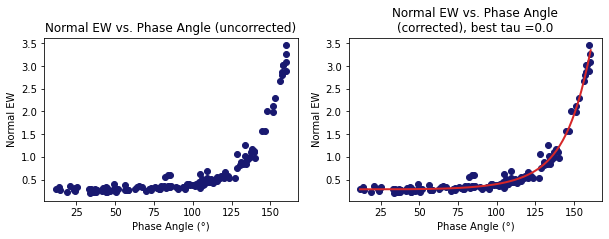

In [16]:
# Plot the phase curve

# create the corrected EW data column
obsdata['C Normal EW'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EW', best_tau_hg))

hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('C Normal EW', None),
                                                        verbose=False)

phase_curve(hg_used_data, phase_col='Mean Phase', uc_ew_col='Normal EW',\
            ew_col='C Normal EW', hg_params=hg_params, best_tau=best_tau_hg)